In [55]:
import os
import gc
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display
from scipy import signal, stats
from scipy.ndimage import gaussian_filter1d

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [56]:
BASE_PATH = Path('/kaggle/input/shl-data')
TRAIN_CSV = BASE_PATH / 'train.csv'
TEST_CSV = BASE_PATH / 'test.csv'

print("Base path exists:", BASE_PATH.exists())
print("Train CSV exists:", TRAIN_CSV.exists())
print("Test CSV exists:", TEST_CSV.exists())


SR = 16000
MAX_DURATION = 60
N_MFCC = 13
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048
SEED = 42

np.random.seed(SEED)


Base path exists: True
Train CSV exists: True
Test CSV exists: True


In [57]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

print(f"Train: {len(train_df)} samples")
print(f"Test: {len(test_df)} samples")
print(f"\nLabel distribution:")
print(train_df['label'].value_counts().sort_index())

Train: 409 samples
Test: 197 samples

Label distribution:
label
1.0      1
1.5      1
2.0     90
2.5     72
3.0    154
3.5     46
4.0     15
4.5     10
5.0     20
Name: count, dtype: int64


In [58]:
def load_audio(file_path):
    try:
        audio, _ = librosa.load(file_path, sr=SR, mono=True)
        audio, _ = librosa.effects.trim(audio, top_db=20)
        
        max_samples = MAX_DURATION * SR
        
        if len(audio) > max_samples:
            audio = audio[:max_samples]
        
        if len(audio) > 0 and np.max(np.abs(audio)) > 0:
            audio = audio / np.max(np.abs(audio))
        
        return audio
    except:
        return np.zeros(SR)

In [59]:
def get_prosody_features(audio):
    feat = {}
    
    f0, voiced_flag, _ = librosa.pyin(audio, fmin=librosa.note_to_hz('C2'), 
                                      fmax=librosa.note_to_hz('C7'), sr=SR)
    f0_clean = f0[~np.isnan(f0)]
    
    if len(f0_clean) > 0:
        feat['pitch_mean'] = np.mean(f0_clean)
        feat['pitch_std'] = np.std(f0_clean)
        feat['pitch_median'] = np.median(f0_clean)
        feat['pitch_range'] = np.ptp(f0_clean)
        feat['pitch_q25'] = np.percentile(f0_clean, 25)
        feat['pitch_q75'] = np.percentile(f0_clean, 75)
        
        if len(f0_clean) > 1:
            pitch_diff = np.diff(f0_clean)
            feat['jitter'] = np.mean(np.abs(pitch_diff))
    else:
        feat = {f'pitch_{k}': 0 for k in ['mean', 'std', 'median', 'range', 'q25', 'q75', 'jitter']}
    
    feat['voiced_ratio'] = np.mean(voiced_flag)
    
    energy = librosa.feature.rms(y=audio)[0]
    feat['energy_mean'] = np.mean(energy)
    feat['energy_std'] = np.std(energy)
    feat['energy_range'] = np.ptp(energy)
    
    return feat


In [60]:
def get_spectral_features(audio):
    feat = {}
    
    sc = librosa.feature.spectral_centroid(y=audio, sr=SR)[0]
    feat['sc_mean'] = np.mean(sc)
    feat['sc_std'] = np.std(sc)
    
    sr_feat = librosa.feature.spectral_rolloff(y=audio, sr=SR)[0]
    feat['rolloff_mean'] = np.mean(sr_feat)
    feat['rolloff_std'] = np.std(sr_feat)
    
    sb = librosa.feature.spectral_bandwidth(y=audio, sr=SR)[0]
    feat['bandwidth_mean'] = np.mean(sb)
    feat['bandwidth_std'] = np.std(sb)
    
    zcr = librosa.feature.zero_crossing_rate(audio)[0]
    feat['zcr_mean'] = np.mean(zcr)
    feat['zcr_std'] = np.std(zcr)
    
    mfccs = librosa.feature.mfcc(y=audio, sr=SR, n_mfcc=N_MFCC)
    for i in range(N_MFCC):
        feat[f'mfcc_{i}_mean'] = np.mean(mfccs[i])
        feat[f'mfcc_{i}_std'] = np.std(mfccs[i])
    
    mfcc_delta = librosa.feature.delta(mfccs)
    for i in range(5):
        feat[f'delta_{i}_mean'] = np.mean(mfcc_delta[i])
    
    return feat

In [61]:
def get_rhythm_features(audio):
    feat = {}
    
    tempo, beats = librosa.beat.beat_track(y=audio, sr=SR)
    feat['tempo'] = tempo
    feat['beat_count'] = len(beats)
    
    onset_env = librosa.onset.onset_strength(y=audio, sr=SR)
    onsets = librosa.onset.onset_detect(onset_envelope=onset_env, sr=SR)
    feat['onset_count'] = len(onsets)
    feat['onset_rate'] = len(onsets) / (len(audio) / SR)
    
    energy = librosa.feature.rms(y=audio)[0]
    silence_thresh = np.percentile(energy, 10)
    is_silence = energy < silence_thresh
    feat['pause_ratio'] = np.mean(is_silence)
    feat['speech_ratio'] = 1 - feat['pause_ratio']
    
    return feat

In [62]:
def extract_features(file_path):
    audio = load_audio(file_path)
   # print(len(audio))
    features = {'duration': len(audio) / SR}
    features.update(get_prosody_features(audio))
    features.update(get_spectral_features(audio))
    features.update(get_rhythm_features(audio))
    
    if features.get('pitch_mean', 0) > 0:
        features['pitch_cv'] = features.get('pitch_std', 0) / features['pitch_mean']
    else:
        features['pitch_cv'] = 0
    
    if features.get('energy_mean', 0) > 0:
        features['energy_cv'] = features.get('energy_std', 0) / features['energy_mean']
    else:
        features['energy_cv'] = 0
    
    features['speech_continuity'] = features.get('speech_ratio', 0) * (1 - features.get('pause_ratio', 0))
    
    return features

In [63]:
def process_data(df):
    features_list = []
    #BASE_PATH = Path("/kaggle/input/shl-data/audios/train")  
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        #file_path = BASE_PATH / row['filename']
        file_path = BASE_PATH / f"{row['filename']}.wav"
        features = extract_features(file_path)
        features_list.append(features)
        #print(file_path, file_path.exists())
    
    features_df = pd.DataFrame(features_list)
    features_df = features_df.fillna(0)
    features_df = features_df.replace([np.inf, -np.inf], 0)
    
    for col in features_df.columns:
        if features_df[col].dtype in [np.float64, np.float32]:
            q99 = features_df[col].quantile(0.99)
            q01 = features_df[col].quantile(0.01)
            features_df[col] = features_df[col].clip(q01, q99)
    
    return features_df

In [66]:
print("Extracting training features...")
BASE_PATH = Path("/kaggle/input/shl-data/audios/train")
X_train = process_data(train_df)
y_train = train_df['label'].values

print(f"Features: {X_train.shape}")

Extracting training features...


  0%|          | 0/409 [00:00<?, ?it/s]

Features: (409, 60)


In [67]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_train)

selector_f = SelectKBest(f_regression, k=min(80, X_train.shape[1]))
selector_f.fit(X_scaled, y_train)

selector_mi = SelectKBest(mutual_info_regression, k=min(80, X_train.shape[1]))
selector_mi.fit(X_scaled, y_train)

combined_support = selector_f.get_support() | selector_mi.get_support()
n_features = np.sum(combined_support)

selector = SelectKBest(f_regression, k=n_features)
X_selected = selector.fit_transform(X_scaled, y_train)

selected_features = X_train.columns[selector.get_support()].tolist()
print(f"Selected {len(selected_features)} features")

Selected 60 features


In [68]:
kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_scores = []
oof_preds = np.zeros(len(y_train))

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_selected), 1):
    X_tr, X_val = X_selected[train_idx], X_selected[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=SEED
    )
    
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], 
             early_stopping_rounds=30, verbose=0)
    
    val_pred = model.predict(X_val)
    oof_preds[val_idx] = val_pred
    
    score = pearsonr(y_val, val_pred)[0]
    cv_scores.append(score)
    print(f"Fold {fold}: {score:.4f}")

print(f"\nMean CV: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

Fold 1: 0.5073
Fold 2: 0.4291
Fold 3: 0.5273
Fold 4: 0.4804
Fold 5: 0.2517

Mean CV: 0.4392 ± 0.0994


In [69]:
models = {}

print("Training XGBoost...")
models['xgb'] = xgb.XGBRegressor(
    n_estimators=1000, learning_rate=0.03, max_depth=6,
    subsample=0.85, colsample_bytree=0.85, random_state=SEED
)
models['xgb'].fit(X_selected, y_train, eval_set=[(X_selected, y_train)],
                 early_stopping_rounds=50, verbose=100)

print("\nTraining LightGBM...")
models['lgb'] = lgb.LGBMRegressor(
    n_estimators=1000, learning_rate=0.03, max_depth=6,
    subsample=0.85, colsample_bytree=0.85, random_state=SEED
)
models['lgb'].fit(X_selected, y_train, eval_set=[(X_selected, y_train)],
                  callbacks=[lgb.early_stopping(50)])

print("\nTraining Random Forest...")
models['rf'] = RandomForestRegressor(
    n_estimators=300, max_depth=10, random_state=SEED, n_jobs=-1
)
models['rf'].fit(X_selected, y_train)

print("\nTraining Extra Trees...")
models['et'] = ExtraTreesRegressor(
    n_estimators=300, max_depth=10, random_state=SEED, n_jobs=-1
)
models['et'].fit(X_selected, y_train)

Training XGBoost...
[0]	validation_0-rmse:0.75521
[100]	validation_0-rmse:0.23825
[200]	validation_0-rmse:0.09329
[300]	validation_0-rmse:0.03728
[400]	validation_0-rmse:0.01526
[500]	validation_0-rmse:0.00636
[600]	validation_0-rmse:0.00265
[700]	validation_0-rmse:0.00110
[800]	validation_0-rmse:0.00054
[900]	validation_0-rmse:0.00047
[999]	validation_0-rmse:0.00046

Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7819
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 60
[LightGBM] [Info] Start training from score 2.910758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

ExtraTreesRegressor(max_depth=10, n_estimators=300, n_jobs=-1, random_state=42)

In [70]:
print("Processing test data...")
BASE_PATH = Path("/kaggle/input/shl-data/audios/test")
X_test = process_data(test_df)
X_test_scaled = scaler.transform(X_test)
X_test_selected = selector.transform(X_test_scaled)

Processing test data...


  0%|          | 0/197 [00:00<?, ?it/s]

In [71]:
weights = {'xgb': 0.35, 'lgb': 0.30, 'rf': 0.20, 'et': 0.15}

test_preds = np.zeros(len(X_test))
for name, model in models.items():
    pred = model.predict(X_test_selected)
    test_preds += pred * weights[name]

test_preds = np.clip(test_preds, 1.0, 5.0)

In [72]:
print(test_df)

       filename
0     audio_141
1     audio_114
2      audio_17
3      audio_76
4     audio_156
..          ...
192   audio_107
193    audio_15
194    audio_93
195  audio_31_1
196   audio_103

[197 rows x 1 columns]


In [73]:
BASE_PATH = Path("/kaggle/input/shl-data")
submission = pd.DataFrame({
    'filename': test_df['filename'],
    'label': test_preds
})

submission.to_csv('submission.csv', index=False)
print(f"Submission saved: {submission.shape}")
print("\nScore distribution:")
print(submission['label'].describe())

Submission saved: (197, 2)

Score distribution:
count    197.000000
mean       2.994266
std        0.380958
min        2.351219
25%        2.733600
50%        2.906277
75%        3.169020
max        4.105261
Name: label, dtype: float64


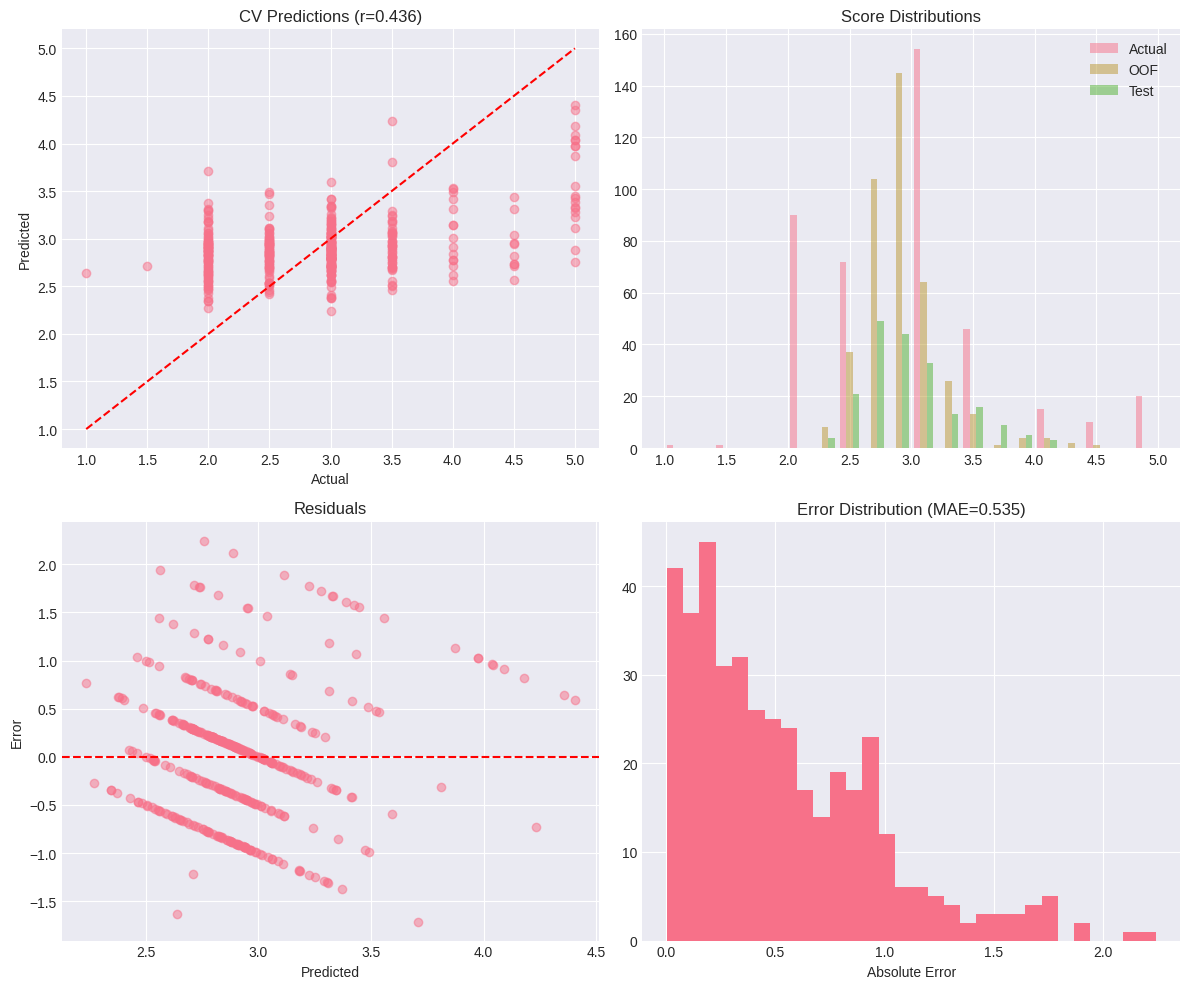

In [74]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0,0].scatter(y_train, oof_preds, alpha=0.5)
axes[0,0].plot([1, 5], [1, 5], 'r--')
axes[0,0].set_title(f'CV Predictions (r={pearsonr(y_train, oof_preds)[0]:.3f})')
axes[0,0].set_xlabel('Actual')
axes[0,0].set_ylabel('Predicted')

axes[0,1].hist([y_train, oof_preds, test_preds], bins=20, alpha=0.5, 
              label=['Actual', 'OOF', 'Test'])
axes[0,1].set_title('Score Distributions')
axes[0,1].legend()

residuals = y_train - oof_preds
axes[1,0].scatter(oof_preds, residuals, alpha=0.5)
axes[1,0].axhline(y=0, color='r', linestyle='--')
axes[1,0].set_title('Residuals')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Error')

axes[1,1].hist(np.abs(residuals), bins=30)
axes[1,1].set_title(f'Error Distribution (MAE={np.mean(np.abs(residuals)):.3f})')
axes[1,1].set_xlabel('Absolute Error')

plt.tight_layout()
plt.show()